# I. Data Importation

In [1]:
import os
import seaborn as sns
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter, defaultdict
import numpy as np
import networkx as nx
from networkx.algorithms.link_prediction import (
    preferential_attachment,
    resource_allocation_index,
    jaccard_coefficient,
)
from math import log
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy
from scipy.stats import pearsonr
import optuna

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit

from torch_geometric.data import InMemoryDataset, Data
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GINConv, global_mean_pool
from torch import nn
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import BaseTransform
from sentence_transformers import SentenceTransformer

c:\Users\ibrah\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


# II. data preprocessing

In [2]:
def convert_annotations(annotation):

    if annotation["is_rumour"] == "nonrumour":
        label = 0 # nonrumour
        
    elif annotation["is_rumour"] == "rumour":
        
        if "misinformation" in annotation.keys() and "true" in annotation.keys():
            
            if int(annotation["misinformation"]) == 0 and int(annotation["true"]) == 0:
                label = 2 # unverified
                    
            elif (int(annotation["misinformation"]) == 0 and int(annotation["true"]) == 1):
                label = 0 # nonrumour
                
            elif (int(annotation["misinformation"]) == 1 and int(annotation["true"]) == 0):
                label = 1 # rumour
                
            elif (int(annotation["misinformation"]) == 1 and int(annotation["true"]) == 1):
                label = 2 # unverified

        elif "misinformation" in annotation.keys() and "true" not in annotation.keys():
            # all instances have misinfo label but don't have true label
            if int(annotation["misinformation"]) == 0:
                label = 2 # unverified
                
            elif int(annotation["misinformation"]) == 1:
                label = 1 # rumour

        elif "true" in annotation.keys() and "misinformation" not in annotation.keys():
            # all instances have true label but don't have misinfo label
            if int(annotation["true"]) == 0:
                label = 2 # unverified
                
            elif int(annotation["true"]) == 1:
                label = 0 # nonrumour
                
        else:
            label = 2 # unverified

    else:
        label = 2 # unverified

    return label









# Load the embedding model once (e.g., all-MiniLM is fast & good)
text_embedder = SentenceTransformer('all-MiniLM-L6-v2')  # 384-dimensional output

def flatten_tweet(tweet_json):
    """Extract a flat numerical + text embedding feature vector from tweet + user info."""
    tweet = tweet_json
    user = tweet.get("user", {})

    # 1. Simple numeric and boolean features from tweet
    tweet_features = [
        tweet.get("favorite_count", 0),
        tweet.get("retweet_count", 0),
        int(tweet.get("possibly_sensitive", False)),
        int(tweet.get("truncated", False)),
        int(tweet.get("retweeted", False)),
        int(tweet.get("favorited", False)),
        len(tweet.get("entities", {}).get("hashtags", [])),
        len(tweet.get("entities", {}).get("user_mentions", [])),
        len(tweet.get("entities", {}).get("urls", [])),
    ]

    # 2. User-based features
    user_features = [
        user.get("followers_count", 0),
        user.get("friends_count", 0),
        user.get("listed_count", 0),
        user.get("favourites_count", 0),
        user.get("statuses_count", 0),
        int(user.get("verified", False)),
        int(user.get("geo_enabled", False)),
        int(user.get("protected", False)),
    ]

    # 3. Text embedding from tweet["text"]
    text = tweet.get("text", "")
    text_embedding = text_embedder.encode(text, show_progress_bar=False)
    
    # 4. Combine everything
    return tweet_features + user_features + text_embedding.tolist()














def extract_edges(structure):
    """Extract edge list from structure.json."""
    edges = []

    def recurse(parent, children):
        if isinstance(children, dict) and len(children) > 0:
            for child, subchildren in children.items():
                edges.append((parent, child))
                recurse(child, subchildren)

    # Fix: handle list or dict at the root
    if isinstance(structure, list):
        for item in structure:
            if isinstance(item, dict):
                for root, children in item.items():
                    recurse(root, children)
    elif isinstance(structure, dict):
        for root, children in structure.items():
            recurse(root, children)
    else:
        raise ValueError("Invalid format for structure.json")

    return edges












class TwitterGraphDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)

        if not os.path.exists(self.processed_paths[0]) :
            self.process()

        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        return []  # unused, folder driven

    @property
    def processed_file_names(self):
        return ["twitter_graphs.pt"]

    def download(self):
        # Not needed, local dataset.
        pass

    def process(self):
        data_list = []
        labels = []

        tweet_dirs = []

        for event in os.listdir('data'):
            event_path = os.path.join('data', event)
            if not os.path.isdir(event_path) or event in ["processed", "raw"] or event.startswith('.'):
                continue
            print(f"Scanning event: {event_path}")

            for label_type in ["rumours", "non-rumours"]:
                label_path = os.path.join(event_path, label_type)
                if not os.path.isdir(label_path):
                    continue

                for thread_id in os.listdir(label_path):
                    if thread_id.startswith('.'):
                        continue
                    thread_path = os.path.join(label_path, thread_id)
                    if os.path.isdir(thread_path):
                        tweet_dirs.append(thread_path)

        print(f"✅ Found {len(tweet_dirs)} threads")

        for tweet_dir in tqdm(tweet_dirs, desc="Building Graphs"):

            structure_file = os.path.join(tweet_dir, "structure.json")
            annotation_file = os.path.join(tweet_dir, "annotation.json")

            if not os.path.exists(structure_file) or not os.path.exists(annotation_file):
                print(f"⚠️ Missing structure or annotation in: {tweet_dir}")
                continue

            with open(structure_file, "r", encoding="utf-8") as f:
                structure = json.load(f)
            with open(annotation_file, "r", encoding="utf-8") as f:
                annotation = json.load(f)

            label = convert_annotations(annotation)
            
            # ignore unverified labels as they do do give good info and hinder model performance
            if label ==2:
                continue
            
            labels.append(label)

            all_tweets = {}

            source_tweet_dir = os.path.join(tweet_dir, "source-tweets")
            reactions_dir = os.path.join(tweet_dir, "reactions")

            if not os.path.exists(source_tweet_dir) or not os.path.exists(reactions_dir):
                print(f"⚠️ Missing source/reactions in: {tweet_dir}")
                continue

            for file in os.listdir(source_tweet_dir):
                if file.startswith('.'):
                    continue
                tweet_id = os.path.splitext(file)[0]
                with open(os.path.join(source_tweet_dir, file), "r", encoding="utf-8") as f:
                    all_tweets[tweet_id] = json.load(f)

            for file in os.listdir(reactions_dir):
                if file.startswith('.'):
                    continue
                tweet_id = os.path.splitext(file)[0]
                with open(os.path.join(reactions_dir, file), "r", encoding="utf-8") as f:
                    all_tweets[tweet_id] = json.load(f)

            node_id_map = {tid: idx for idx, tid in enumerate(all_tweets.keys())}
            node_features = [flatten_tweet(all_tweets[tid]) for tid in all_tweets]
            x = torch.tensor(node_features, dtype=torch.float)

            edge_list = extract_edges(structure)
            try:
                edge_index = (
                    torch.tensor(
                        [[node_id_map[src], node_id_map[dst]] for src, dst in edge_list],
                        dtype=torch.long,
                    )
                    .t()
                    .contiguous()
                )
            except KeyError as e:
                print(f"❌ Edge points to missing tweet ID {e} in {tweet_dir}")
                continue

            data = Data(x=x, edge_index=edge_index)

            data.y = torch.tensor([label], dtype=torch.long)
            data_list.append(data)



        if len(data_list) == 0:
            raise RuntimeError("No valid tweet threads found. Aborting.")

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        print(f"✅ Saved {len(data_list)} graphs to {self.processed_paths[0]}")
        


# III. Feature engineering

In [3]:
def second_order_preferential_attachment(G, ebunch):
    for u, v in ebunch:
        sum_u = sum(G.degree(nbr) for nbr in G[u])
        sum_v = sum(G.degree(nbr) for nbr in G[v])
        yield (u, v, sum_u * sum_v)

def safe_adamic_adar_index(G, ebunch):
    for u, v in ebunch:
        score = 0.0
        for w in nx.common_neighbors(G, u, v):
            deg = G.degree(w)
            if deg > 1:
                score += 1.0/log(deg)
        yield (u, v, score)

def compute_node_level_features(data: Data):
    """
    Given one PyG Data graph, returns a torch.FloatTensor of shape [N, K]
    of new node features built by aggregating edge‑based scores and other
    classic node metrics.
    """
    # 1) Build a NetworkX graph
    G = nx.Graph()
    N = data.x.size(0)
    G.add_nodes_from(range(N))
    src, dst = data.edge_index
    edges = list(zip(src.tolist(), dst.tolist()))
    G.add_edges_from(edges)
    
    # 2) Precompute edge‑scores for ALL edges once
    ebunch = list(G.edges())
    # each of these is an iterator of (u,v,score)
    pa  = dict(((u,v),s) for u,v,s in preferential_attachment(G, ebunch))
    ra  = dict(((u,v),s) for u,v,s in resource_allocation_index(G, ebunch))
    aa  = dict(((u,v),s) for u,v,s in safe_adamic_adar_index(G, ebunch))
    jc  = dict(((u,v),s) for u,v,s in jaccard_coefficient(G, ebunch))
    pa2 = dict(((u,v),s) for u,v,s in second_order_preferential_attachment(G, ebunch))
    
    # 3) HITS, clustering, betweenness (global once)
    try:
        hubs, auths = nx.hits(G, max_iter=500, normalized=True)
    except:
        hubs, auths = {n:0 for n in G}, {n:0 for n in G}
    clustering = nx.clustering(G)
    betw = nx.betweenness_centrality(G)
    
    # 4) For each node, gather its incident‑edge scores & aggregate
    records = []
    for node in range(N):
        nbrs = list(G.neighbors(node))
        feats = []
        # helper to pull a score dict with symmetric lookup
        def get_scores(d):
            vals = []
            for nbr in nbrs:
                vals.append(d.get((node,nbr), d.get((nbr,node), 0.0)))
            return np.array(vals) if vals else np.array([0.0])
        
        # for each link‑pred measure, compute [mean, sum, max, std]
        for d in (pa, ra, aa, jc, pa2):
            arr = get_scores(d)
            feats.extend([arr.mean(), arr.sum(), arr.max(), arr.std()])
        
        # add degree, clustering, betweenness, hub, authority
        feats.append(G.degree(node))
        feats.append(clustering.get(node, 0.0))
        feats.append(betw.get(node, 0.0))
        feats.append(hubs.get(node, 0.0))
        feats.append(auths.get(node, 0.0))
        
        records.append(feats)
    
    arr = np.vstack(records).astype(np.float32)   # shape [N, K]
    return torch.from_numpy(arr)

In [4]:
class AddNetworkFeatures(BaseTransform):
    def __call__(self, data):
        new_feats = compute_node_level_features(data)
        data.x = torch.cat([data.x, new_feats], dim=1)
        return data

In [5]:
dataset = TwitterGraphDataset(root="data", transform=AddNetworkFeatures())

# IV. Data Understanding

In [6]:
# 1. Number of graphs (threads)
num_graphs = len(dataset)
print(f"Number of graphs (threads) in dataset: {num_graphs}")

# 2. Distribution of class labels
labels = [int(data.y.item()) for data in dataset]  
label_counts = Counter(labels)
class_names = {0: "nonrumour", 1: "rumour"}  
print("Class distribution:")
for lbl, count in label_counts.items():
    perc = 100 * count / num_graphs
    print(f"  {class_names.get(lbl, lbl)}: {count} graphs ({perc:.1f}%)")

# 3. Nodes and edges per graph
num_nodes = [data.x.size(0) for data in dataset]        # number of nodes in each graph
num_edges = [data.edge_index.size(1) for data in dataset]  # number of edges in each graph
print(f"Average nodes per graph: {np.mean(num_nodes):.2f} ± {np.std(num_nodes):.2f}")
print(f"Average edges per graph: {np.mean(num_edges):.2f} ± {np.std(num_edges):.2f}")
print(f"Max nodes in a graph: {np.max(num_nodes)}, Min nodes: {np.min(num_nodes)}")
print(f"Max edges in a graph: {np.max(num_edges)}, Min edges: {np.min(num_edges)}")

# 4. Number of node features
if dataset[0].x is not None:
    feature_dim = dataset[0].x.size(1)
    print(f"Number of node features (feature vector length): {feature_dim}")


Number of graphs (threads) in dataset: 5726


c:\Users\ibrah\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:89: RuntimeWarning: invalid value encountered in divide
  h /= h.sum()


Class distribution:
  nonrumour: 5089 graphs (88.9%)
  rumour: 637 graphs (11.1%)
Average nodes per graph: 16.32 ± 19.63
Average edges per graph: 14.87 ± 18.98
Max nodes in a graph: 346, Min nodes: 1
Max edges in a graph: 345, Min edges: 0
Number of node features (feature vector length): 426


# V. ML approach

## 1. Create input and output tensors

In [7]:
# Create feature vectors for each graph
X = []
y = []
for data in dataset:
    # Aggregate node feature (mean)
    if data.x is not None:
        mean_features = data.x.mean(dim=0).tolist()
    else:
        mean_features = []  # handle case with no node features

    X.append(mean_features)
    y.append(int(data.y.item()))

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=int)
print("Feature matrix shape:", X.shape)  # (num_graphs, feature_dim)
print("Labels array shape:", y.shape)


Feature matrix shape: (5726, 426)
Labels array shape: (5726,)


## 2. feature selection


### a. nan values elimination

In [8]:
print("NaNs in X:", np.isnan(X).sum())
print("Infs in X:", np.isinf(X).sum())
print("NaNs in y:", np.isnan(y).sum())
print("Infs in y:", np.isinf(y).sum())

NaNs in X: 6
Infs in X: 0
NaNs in y: 0
Infs in y: 0


In [9]:
# Remove rows in X (and corresponding y) that contain NaNs
mask = ~np.isnan(X).any(axis=1)

X_clean = X[mask]
y_clean = y[mask]

### b. Low variance elimination

In [10]:
std_columns = np.std(X_clean, axis=0)

In [11]:

print('Number of features per std value:')
Counter(np.sort(std_columns))

Number of features per std value:


Counter({0.0: 19,
         3.7636934e-09: 1,
         0.01673728: 1,
         0.019424902: 1,
         0.020520307: 1,
         0.020535484: 1,
         0.021284144: 1,
         0.021781107: 1,
         0.021851424: 1,
         0.022174835: 1,
         0.022334233: 1,
         0.02270261: 1,
         0.022754116: 1,
         0.02286422: 1,
         0.022971656: 1,
         0.023106711: 1,
         0.023384571: 1,
         0.023432769: 1,
         0.023581553: 1,
         0.023591924: 1,
         0.023636969: 1,
         0.023731168: 1,
         0.023823407: 1,
         0.02392199: 1,
         0.023980467: 1,
         0.023985097: 1,
         0.024042089: 1,
         0.024095131: 1,
         0.024106165: 1,
         0.024106292: 1,
         0.024174329: 1,
         0.024308383: 1,
         0.02433526: 1,
         0.024336552: 1,
         0.024359325: 1,
         0.024409425: 1,
         0.024521913: 1,
         0.024522068: 1,
         0.02456532: 1,
         0.024680838: 1,
         0.

* As we can see, we have 19 features with almost 0 std. These features will hinder performance. Thus they must be eliminated. 

In [12]:
mask = ~(np.std(X_clean, axis=0) == 0.0)
X_clean = X_clean[:, mask]
print(f'The ramaining number of features is:\t{X_clean.shape[1]}')

The ramaining number of features is:	407


### c. Filter Methods

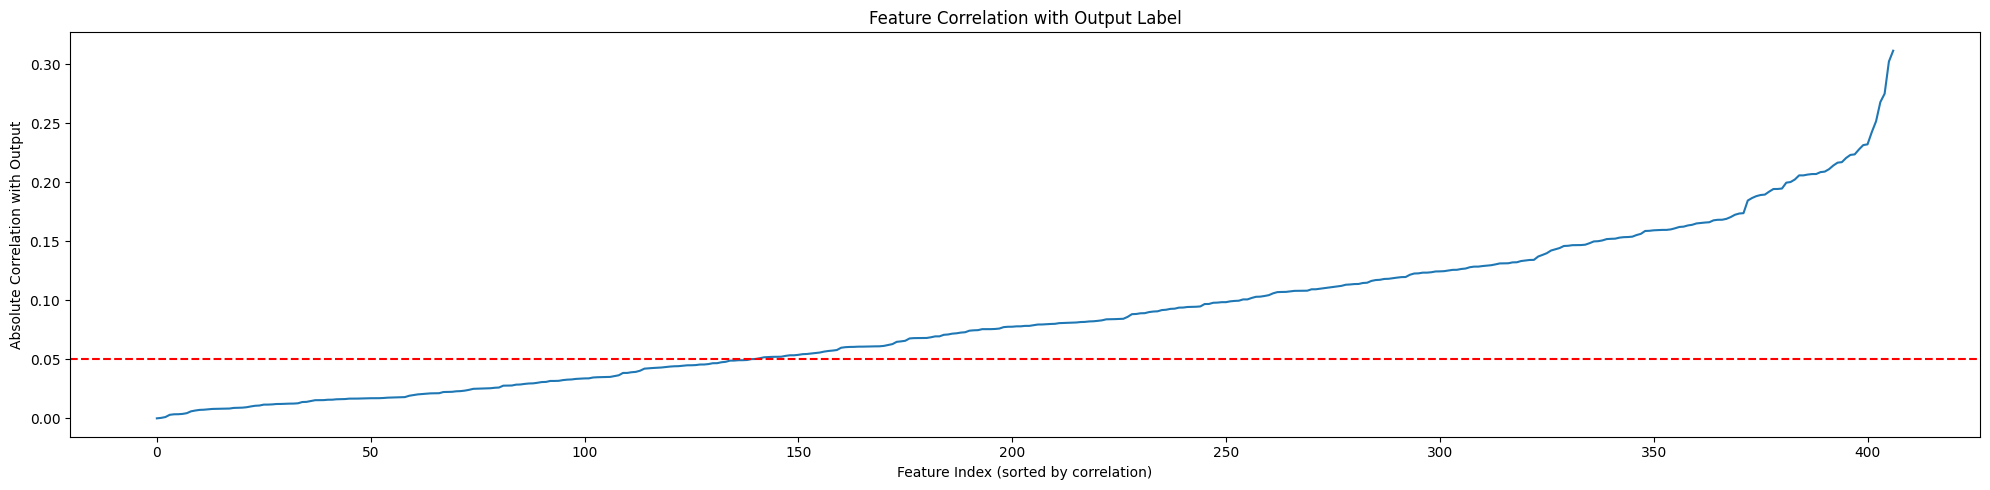

In [17]:
# Compute correlation
correlations = np.zeros(X_clean.shape[1])
for col in range(X_clean.shape[1]):
    correlations[col] = pearsonr(X_clean[:, col], y_clean)[0]

# Sort by absolute correlation
sorted_indices = np.argsort(np.abs(correlations))
sorted_correlations = np.abs(correlations[sorted_indices])

# Plot
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(range(len(sorted_correlations)), sorted_correlations)

# Add horizontal threshold line at 0.05
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold = 0.05')


plt.xlabel("Feature Index (sorted by correlation)")
plt.ylabel("Absolute Correlation with Output")
plt.title("Feature Correlation with Output Label")
plt.tight_layout()
plt.show()


In [18]:
# We will keep only features with corr>=0.05
X_clean = X_clean[:, sorted_indices[sorted_correlations>=0.05]]
print(f"There are {X_clean.shape[1]} features left.")

There are 268 features left.


### d. Multicollinearity

In [19]:
# We ffix the correclation threshold between features
correlation_threshold = 0.9

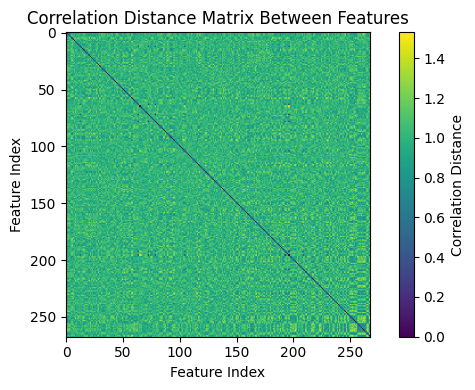

In [20]:
# Plot the correlation atrix between features

# Compute correlation distance matrix
corr = pdist(X_clean.T, metric="correlation")
corr_matrix = squareform(corr)

# Plot with colorbar
plt.figure(figsize=(6, 4))
im = plt.imshow(corr_matrix, cmap='viridis')  # You can change the colormap if you like
plt.colorbar(im, label='Correlation Distance')  # This shows the scale of values

plt.title("Correlation Distance Matrix Between Features")
plt.xlabel("Feature Index")
plt.ylabel("Feature Index")
plt.tight_layout()
plt.show()

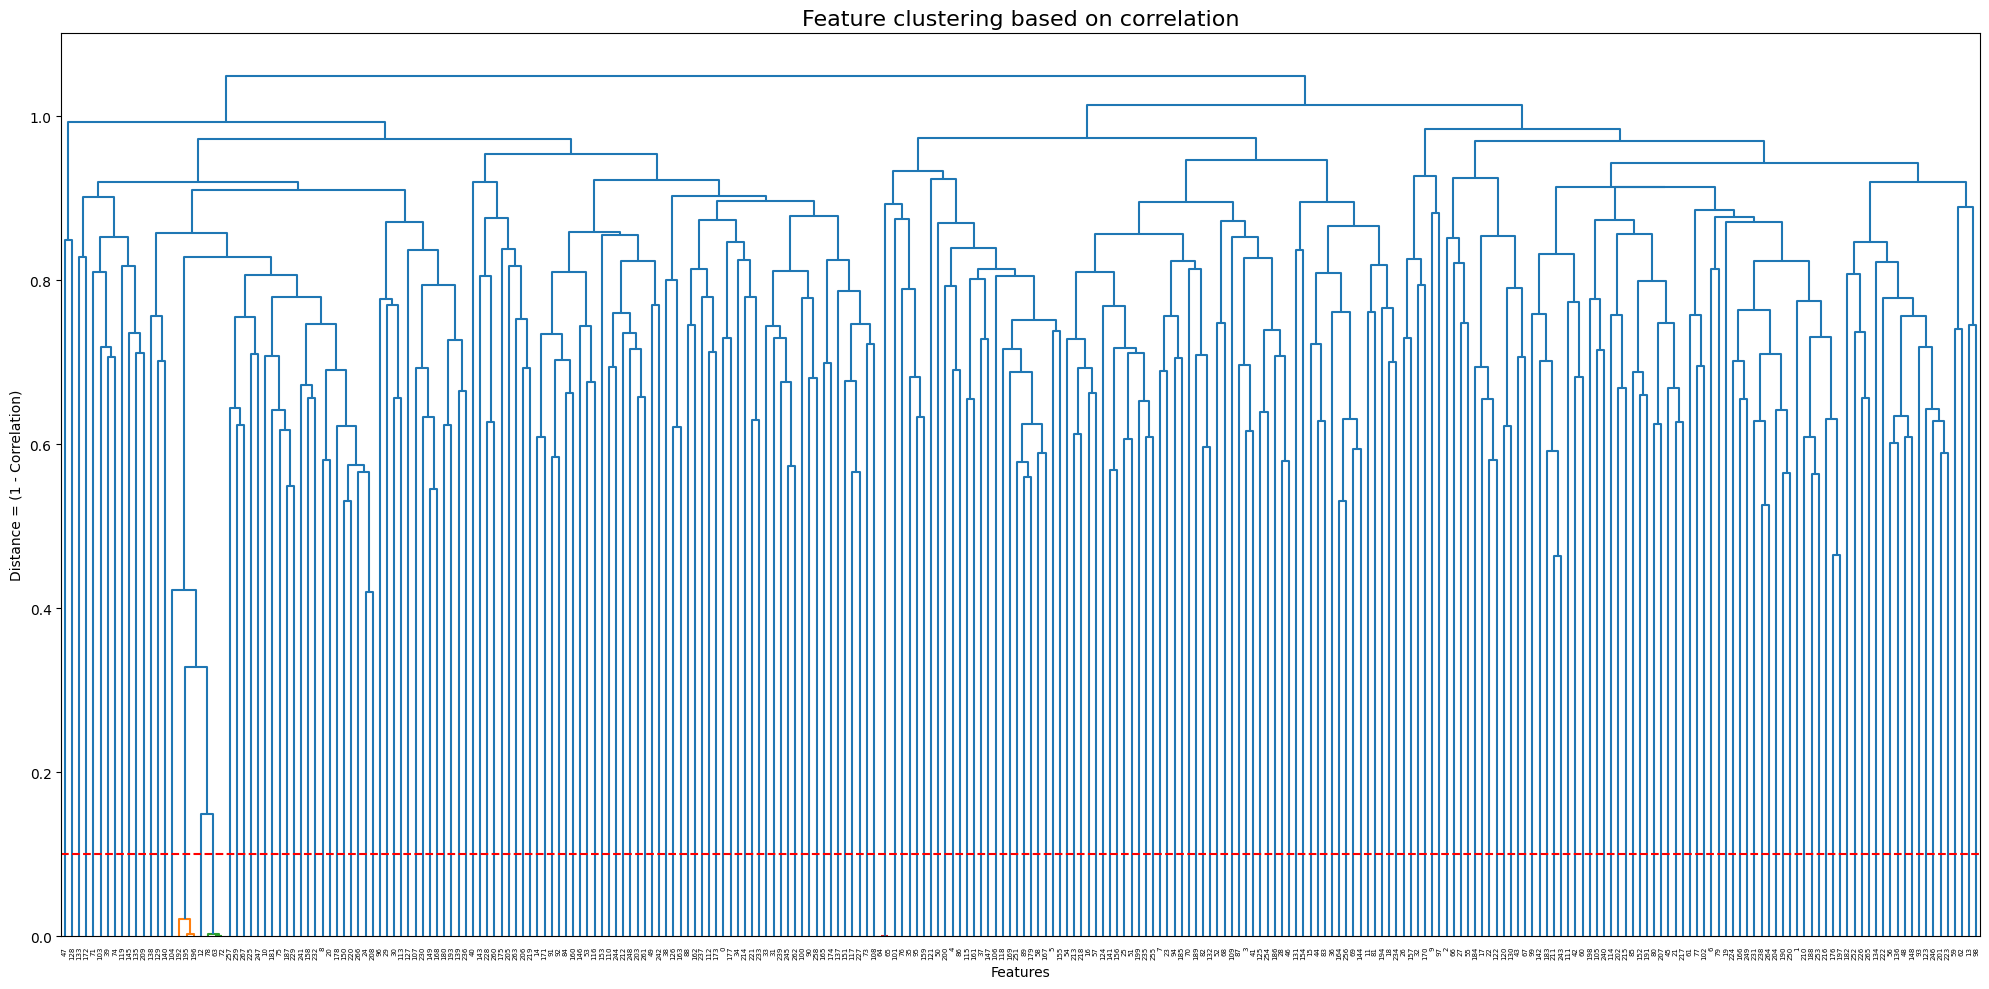

In [21]:
# We cluster features based on their correlation score
# We color most correlated features to eliminate them
fig, ax = plt.subplots(figsize=(20, 10))
corr_linkage = hierarchy.average(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, ax=ax, color_threshold=1 - correlation_threshold
)
# Add horizontal threshold line at distance = 0.1
ax.axhline(y=0.1, color='red', linestyle='--', label='Threshold = 0.1')

ax.set_title("Feature clustering based on correlation", fontsize=16)
plt.xlabel("Features")
plt.ylabel("Distance = (1 - Correlation)")
plt.tight_layout()
plt.show()

* We get a hierarchical clustering of features based on pairwise correlation distances (i.e., 1 - correlation| between features).
* The vertical height of each merge represents the correlation distance between clusters (i.e., how dissimilar two groups of features are).
* The color_threshold=1 - correlation_threshold highlights clusters of features that are strongly correlated (e.g., correlation ≥ 0.9) by coloring them the same.
* Clusters that are closely merged (low height) likely contain redundant features, and one can be dropped to reduce multicollinearity.
* As we can see, there are some features which are very correlated (correlation more than 0.9). 
* For Every cluster of correlated features (every different color), we take only one feature.

In [19]:
# compute the clusters
cluster_ids = hierarchy.fcluster(
    corr_linkage, 1 - correlation_threshold, criterion="distance"
)

# for each cluster, only keep the first feature
keep_features = list()
for cluster in np.unique(cluster_ids):
    cluster_indexes = np.where(cluster_ids == cluster)[0]
    keep_features.append(cluster_indexes[0])

In [20]:
# on maintient seulement les colonnes qui ne sont pas corrélés
X_clean = X_clean[:, keep_features]
print(f"There are {X_clean.shape[1]} features left.")

There are 263 features left.


## 3. train val test split

In [21]:
# Stratified 70/15/15 split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
train_val_idx, test_idx = next(sss.split(X_clean, y_clean))
X_train_val, X_test = X_clean[train_val_idx], X_clean[test_idx]
y_train_val, y_test = y_clean[train_val_idx], y_clean[test_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.1765, random_state=42)  # 0.1765 of 85% ≈ 15% of total
train_idx, val_idx = next(sss2.split(X_train_val, y_train_val))
X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

print(f"Train size: {len(y_train)}, Val size: {len(y_val)}, Test size: {len(y_test)}")

print("Class distribution in Training:")
train_dist = Counter(y_train)
total_train = sum(train_dist.values())
for cls, count in train_dist.items():
    print(f"  Class {cls}: {count} samples ({100 * count / total_train:.2f}%)")

print("Class distribution in Validation:")
val_dist = Counter(y_val)
total_val = sum(val_dist.values())
for cls, count in val_dist.items():
    print(f"  Class {cls}: {count} samples ({100 * count / total_val:.2f}%)")

print("Class distribution in Test:")
test_dist = Counter(y_test)
total_test = sum(test_dist.values())
for cls, count in test_dist.items():
    print(f"  Class {cls}: {count} samples ({100 * count / total_test:.2f}%)")

Train size: 4003, Val size: 859, Test size: 858
Class distribution in Training:
  Class 1: 445 samples (11.12%)
  Class 0: 3558 samples (88.88%)
Class distribution in Validation:
  Class 0: 763 samples (88.82%)
  Class 1: 96 samples (11.18%)
Class distribution in Test:
  Class 0: 763 samples (88.93%)
  Class 1: 95 samples (11.07%)


## 4. Classifier training + hyperparameters tuning

* Since our data is imbalanced, we need to use the F1 score rather than accuracy. 
* Here we will use F1 score with average='binary' (default setting). This will calculates the F1-score for the positive class (minority class) that we are concentrated in. 

### a. Random Forest Classifier

In [22]:
def objective_rf(trial):
    # Hyperparameter search space for Random Forest
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    # You could also tune min_samples_split, min_samples_leaf, etc.
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                 class_weight="balanced", random_state=0)  
    pipeline = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
    pipeline.fit(X_train, y_train)
    # Predict on validation set
    y_pred = pipeline.predict(X_val)
    # Compute F1 score on val
    score = f1_score(y_val, y_pred) 
    return score

# Optimize Random Forest hyperparameters
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50, timeout=600)  # 50 trials or 10 minutes
print("Best RF params:", study_rf.best_params)
print("Best RF validation F1:", study_rf.best_value)


[I 2025-04-24 22:53:10,929] A new study created in memory with name: no-name-94cec18f-fd4c-4050-af74-802d46ae22af
[I 2025-04-24 22:53:20,915] Trial 0 finished with value: 0.4262295081967213 and parameters: {'n_estimators': 222, 'max_depth': 16}. Best is trial 0 with value: 0.4262295081967213.
[I 2025-04-24 22:53:23,362] Trial 1 finished with value: 0.4262295081967213 and parameters: {'n_estimators': 56, 'max_depth': 19}. Best is trial 0 with value: 0.4262295081967213.
[I 2025-04-24 22:53:32,239] Trial 2 finished with value: 0.48854961832061067 and parameters: {'n_estimators': 251, 'max_depth': 8}. Best is trial 2 with value: 0.48854961832061067.
[I 2025-04-24 22:53:39,200] Trial 3 finished with value: 0.43902439024390244 and parameters: {'n_estimators': 186, 'max_depth': 10}. Best is trial 2 with value: 0.48854961832061067.
[I 2025-04-24 22:53:42,561] Trial 4 finished with value: 0.4262295081967213 and parameters: {'n_estimators': 80, 'max_depth': 15}. Best is trial 2 with value: 0.488

Best RF params: {'n_estimators': 203, 'max_depth': 6}
Best RF validation F1: 0.54421768707483


### b. Support Vector Machine (SVM)


In [23]:
def objective_svm(trial):
    C = trial.suggest_loguniform("C", 1e-3, 1e2)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
    # Only use gamma in RBF kernel
    if kernel == "rbf":
        gamma = trial.suggest_loguniform("gamma", 1e-4, 1e-1)
    else:
        gamma = "scale"  # default
    clf = SVC(C=C, kernel=kernel, gamma=gamma, class_weight="balanced", probability=False, random_state=0)
    pipeline = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    score = f1_score(y_val, y_pred)
    return score

study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=50, timeout=600)
print("Best SVM params:", study_svm.best_params)
print("Best SVM validation F1:", study_svm.best_value)


[I 2025-04-24 22:58:01,672] A new study created in memory with name: no-name-df8babc0-03e0-40ee-93f9-b99a9146fa01
C:\Users\ibrah\AppData\Local\Temp\ipykernel_9352\1267725424.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e2)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_9352\1267725424.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform("gamma", 1e-4, 1e-1)
[I 2025-04-24 22:58:04,462] Trial 0 finished with value: 0.2723735408560311 and parameters: {'C': 0.021849076623190522, 'kernel': 'rbf', 'gamma': 0.00736572026972956}. Best is trial 0 with value: 0.2723735408560311.
C:\Users\ibrah\AppData\Lo

Best SVM params: {'C': 39.49742451610962, 'kernel': 'rbf', 'gamma': 0.0006365226238232686}
Best SVM validation F1: 0.59375


### c. Gradient Boosting Classifier

In [25]:
def objective_gb(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-2, 1e0)
    max_depth = trial.suggest_int("max_depth", 2, 10)
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate,
                                     max_depth=max_depth, random_state=0)
    pipeline = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    score = f1_score(y_val, y_pred)
    return score

study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials=50, timeout=600)
print("Best GB params:", study_gb.best_params)
print("Best GB validation F1:", study_gb.best_value)


[I 2025-04-24 23:25:11,526] A new study created in memory with name: no-name-057bfbb5-b6d6-4674-b9ab-b72115e59fa1
C:\Users\ibrah\AppData\Local\Temp\ipykernel_9352\306881506.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-2, 1e0)
[I 2025-04-24 23:27:03,813] Trial 0 finished with value: 0.5277777777777778 and parameters: {'n_estimators': 244, 'learning_rate': 0.6721230230558463, 'max_depth': 7}. Best is trial 0 with value: 0.5277777777777778.
C:\Users\ibrah\AppData\Local\Temp\ipykernel_9352\306881506.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate",

Best GB params: {'n_estimators': 148, 'learning_rate': 0.34519479074615367, 'max_depth': 4}
Best GB validation F1: 0.5531914893617021


After tuning, we have the best hyperparameters for each model (based on validation F1). Now we compare their performance.

## 5. Evaluation of ML classifier

We retrain each classifier on the combined training+validation data (85% of dataset) with the best found hyperparameters, then evaluate on the test set:

Random Forest Test Accuracy: 0.921911421911422
Random Forest Test F1: 0.5562913907284768
SVM Test Accuracy: 0.9184149184149184
SVM Test F1: 0.6464646464646465
Gradient Boosting Test Accuracy: 0.9289044289044289
Gradient Boosting Test F1: 0.5850340136054422

Classification report for best ML model on test set:
              precision    recall  f1-score   support

   nonrumour       0.96      0.95      0.95       763
      rumour       0.62      0.67      0.65        95

    accuracy                           0.92       858
   macro avg       0.79      0.81      0.80       858
weighted avg       0.92      0.92      0.92       858



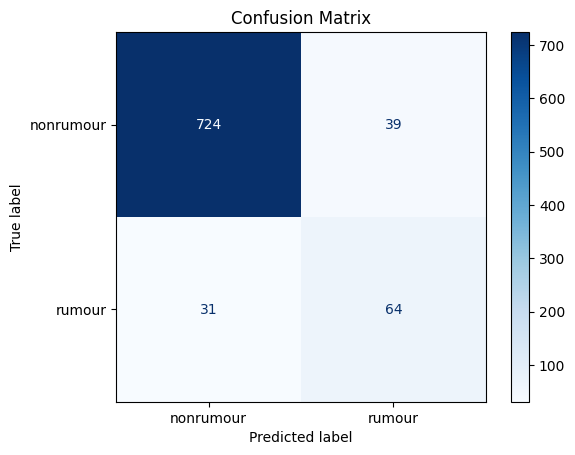

In [35]:
# Prepare combined train+val sets for final training
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

# 1. Random Forest with best params
rf_best = RandomForestClassifier(**study_rf.best_params, class_weight="balanced", random_state=0)
pipeline_rf = Pipeline([('scaler', StandardScaler()), ('clf', rf_best)])
pipeline_rf.fit(X_train_full, y_train_full)
y_pred_rf = pipeline_rf.predict(X_test)
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Test F1:", f1_score(y_test, y_pred_rf))

# 2. SVM with best params
svm_best = SVC(**study_svm.best_params, class_weight="balanced", random_state=0)
pipeline_svm = Pipeline([('scaler', StandardScaler()), ('clf', svm_best)])
pipeline_svm.fit(X_train_full, y_train_full)
y_pred_svm = pipeline_svm.predict(X_test)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Test F1:", f1_score(y_test, y_pred_svm))

# 3. Gradient Boosting with best params
gb_best = GradientBoostingClassifier(**study_gb.best_params, random_state=0)
pipeline_gb = Pipeline([('scaler', StandardScaler()), ('clf', gb_best)])
pipeline_gb.fit(X_train_full, y_train_full)
y_pred_gb = pipeline_gb.predict(X_test)
print("Gradient Boosting Test Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Gradient Boosting Test F1:", f1_score(y_test, y_pred_gb))

# Compare performance
print("\nClassification report for best ML model on test set:")
# Determine which model had highest validation F1
val_scores = {
    "RandomForest": study_rf.best_value,
    "SVM": study_svm.best_value,
    "GradientBoosting": study_gb.best_value
}
best_ml_model = max(val_scores, key=val_scores.get)
if best_ml_model == "RandomForest":
    y_pred_best_ml = y_pred_rf
elif best_ml_model == "SVM":
    y_pred_best_ml = y_pred_svm
else:
    y_pred_best_ml = y_pred_gb

# print(f"Best ML model: {best_ml_model}")
print(classification_report(y_test, y_pred_best_ml, target_names=[class_names[0], class_names[1]]))


# Actual counts
cm = confusion_matrix(y_test, y_pred_best_ml)

# Class labels
labels = [class_names[0], class_names[1]]

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot it
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

The confusion matrix shows that the model performs well on the dominant class nonrumour, correctly classifying 724 out of 763 instances (94,8% accuracy), with only 39 misclassified as rumour. However, performance on the rumour class remains limited, with 64 out of 95 correctly identified (68% recall) and 31 misclassified as nonrumour. This indicates reasonably acceptable performance on on positive class (minority class).